#### **Importing Libraries and Data**

In [26]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

df = pd.read_csv('bioactivity_of_EGFR_inhibitors.csv')
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,CHEMBL304929,C#Cc1cccc(Nc2ncnc3cc(OC)c(OC)cc23)c1,140.0,inactive
1,CHEMBL1092250,C#Cc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,1500.0,inactive
2,CHEMBL553,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,1000.0,inactive
3,CHEMBL1089203,C#Cc1cccc(Nc2ccnc3cc(OCCOC)c(OCCOC)cc23)c1,1500.0,inactive
4,CHEMBL1088901,CN(C)CCCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,190.0,inactive


### Calculate Lipinski descriptors
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the *druglikeness* of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the [**pharmacokinetic profile**](https://www.annualreviews.org/doi/10.1146/annurev-anchem-061417-125611#:~:text=A%20PK%20profile%20is%20generally,typically%20referred%20to%20as%20ADME.). Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or [Lipinski's Rule](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2728118/)

The Lipinski's Rule stated the following:

1. Molecular weight < 500 Dalton
2. Octanol-water partition coefficient (LogP) < 5 (can be interpreted as lipophilicty)
3. Hydrogen bond donors < 5
4. Hydrogen bond acceptors < 10

[Function inspiration](https://codeocean.com/explore/capsules?query=tag:data-curation)

In [27]:
def lipinski(smiles, verbose=False):
    
    # Inputs: smiles string list 
    # Outputs: descriptors dataframe with Lipinski parameters
    # This function uses the rdkit.Chem library to contruct mol objects from parsing through SMILES strings 
    # Then uses the rdkit.Descriptors and rdkit.Lipinski libraries to find Lipinski parameters 

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
       
    baseData= np.arange(1,1)
   
    for i, mol in enumerate(moldata):        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])     
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [28]:
df_lipinski = lipinski(df.canonical_smiles)
df_combined = pd.concat([df, df_lipinski], axis=1)
df_combined.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL304929,C#Cc1cccc(Nc2ncnc3cc(OC)c(OC)cc23)c1,140.0,inactive,305.337,3.3719,1.0,5.0
1,CHEMBL1092250,C#Cc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,1500.0,inactive,304.349,3.9769,1.0,4.0
2,CHEMBL553,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,1000.0,inactive,393.443,3.4051,1.0,7.0
3,CHEMBL1089203,C#Cc1cccc(Nc2ccnc3cc(OCCOC)c(OCCOC)cc23)c1,1500.0,inactive,392.455,4.0101,1.0,6.0
4,CHEMBL1088901,CN(C)CCCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,190.0,inactive,428.334,4.4162,2.0,5.0


### Convert IC50 to pIC50
To uniformly distribute IC50 data by means of conversion to a negative logarithmic scale 

In [29]:
def pIC50(dataframe):
    
    # Inputs: Combined dataframe 
    # Outputs: Dropped dataframe from dataframe
    # Converts IC50 dataframe from nM to M, applies -log10, and creates a new pIC50 column
    
    pIC50 = []

    for val in dataframe['standard_value']:
        molar = val*(10**-9)
        pIC50.append(-np.log10(molar))

    dataframe['pIC50'] = pIC50
    x = dataframe.drop('standard_value', axis=1)
        
    return x

In [30]:
df_final = pIC50(df_combined)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL304929,C#Cc1cccc(Nc2ncnc3cc(OC)c(OC)cc23)c1,inactive,305.337,3.3719,1.0,5.0,6.853872
1,CHEMBL1092250,C#Cc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,inactive,304.349,3.9769,1.0,4.0,5.823909
2,CHEMBL553,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,inactive,393.443,3.4051,1.0,7.0,6.000000
3,CHEMBL1089203,C#Cc1cccc(Nc2ccnc3cc(OCCOC)c(OCCOC)cc23)c1,inactive,392.455,4.0101,1.0,6.0,5.823909
4,CHEMBL1088901,CN(C)CCCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,inactive,428.334,4.4162,2.0,5.0,6.721246
...,...,...,...,...,...,...,...,...
158,CHEMBL3985592,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC4CN(CCF)C4)cc3O...,active,545.541,5.1813,4.0,8.0,8.301030
159,CHEMBL3956925,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC4CN(C(C)=O)C4)c...,active,541.534,4.7583,4.0,8.0,8.301030
160,CHEMBL3967836,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC4CN(C(=O)OC(C)(...,inactive,599.614,6.1469,4.0,9.0,6.698970
161,CHEMBL3962343,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC(C)C)cc3OC)ncc2...,intermediate,452.946,5.5706,4.0,7.0,7.187087


### Removal of 'intermediate' bioactivity compounds

To allow for simple binary comparisons of active vs inactive compounds


In [31]:
df_final2 = df_final[df_final.bioactivity != 'intermediate']
df_final2

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL304929,C#Cc1cccc(Nc2ncnc3cc(OC)c(OC)cc23)c1,inactive,305.337,3.3719,1.0,5.0,6.853872
1,CHEMBL1092250,C#Cc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,inactive,304.349,3.9769,1.0,4.0,5.823909
2,CHEMBL553,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,inactive,393.443,3.4051,1.0,7.0,6.000000
3,CHEMBL1089203,C#Cc1cccc(Nc2ccnc3cc(OCCOC)c(OCCOC)cc23)c1,inactive,392.455,4.0101,1.0,6.0,5.823909
4,CHEMBL1088901,CN(C)CCCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,inactive,428.334,4.4162,2.0,5.0,6.721246
...,...,...,...,...,...,...,...,...
155,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,active,446.910,4.2756,1.0,7.0,9.195861
156,CHEMBL3622673,C#Cc1cccc(Nc2ncnc3cc(OCC)c(NC(=O)/C=C/CN4CCCCC...,active,455.562,4.7340,2.0,6.0,8.769551
158,CHEMBL3985592,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC4CN(CCF)C4)cc3O...,active,545.541,5.1813,4.0,8.0,8.301030
159,CHEMBL3956925,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(NC4CN(C(C)=O)C4)c...,active,541.534,4.7583,4.0,8.0,8.301030


### **Data Analysis**

In [32]:
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt

#### Frequency plot of active vs inactive compounds
Remember: Active vs Inactive represents IC50 threshold values defined in EGFR_data_collection.ipynb

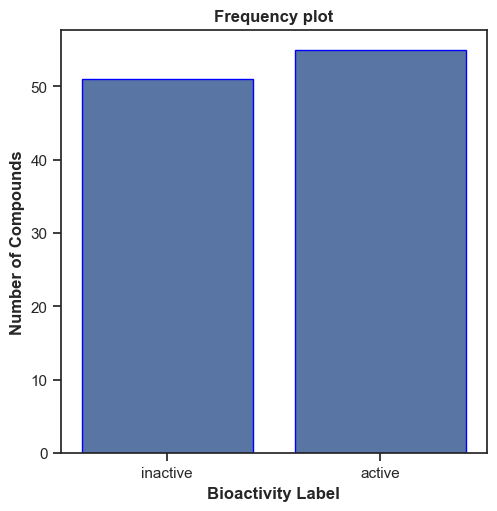

In [35]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity', data=df_final2, edgecolor='blue')
plt.title('Frequency plot', fontweight='bold')
plt.xlabel('Bioactivity Label', fontweight='bold')
plt.ylabel('Number of Compounds', fontweight='bold')
plt.show()

#### Scatter plot of MW versus LogP
Molecular weight vs lipophilicty 

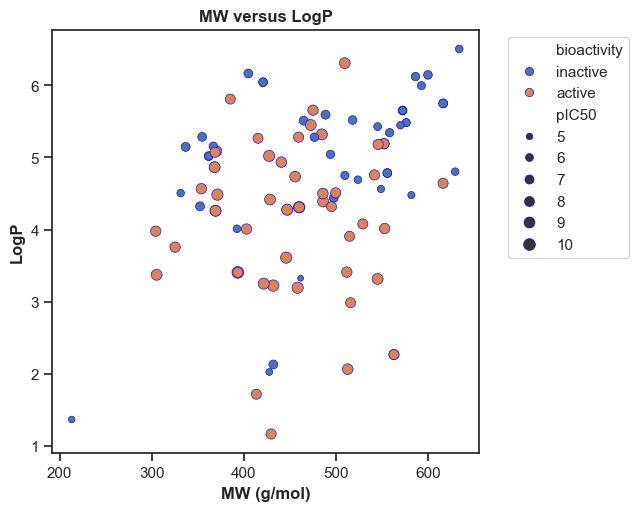

In [40]:
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='LogP', hue='bioactivity', size='pIC50', data=df_final2, edgecolor='blue')
plt.title('MW versus LogP', fontweight='bold')
plt.xlabel('MW (g/mol)', fontweight='bold')
plt.ylabel('LogP', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

#### Box plot of pIC50 values

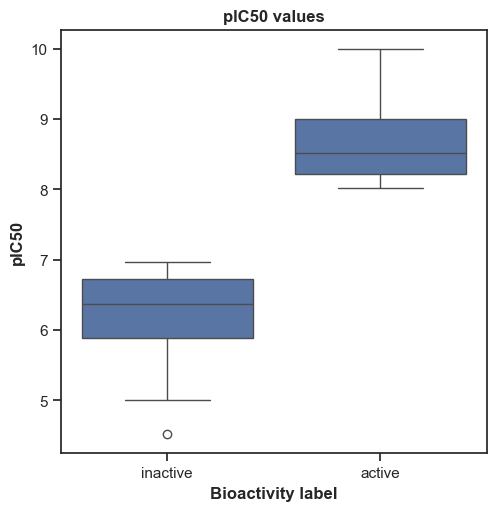

In [41]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x='bioactivity', y='pIC50', data=df_final2)
plt.title('pIC50 values', fontweight='bold')
plt.xlabel('Bioactivity label', fontweight='bold')
plt.ylabel('pIC50', fontweight='bold')
plt.show()

Need to: 
1. Write functions for Mann-Whitney tests
2. Replace above plots with subplots showing all 4 categories of Lipinski model
3. Find which compounds could potentially be drugs according to Lipinski model